# ピーターと狼: 強化学習入門

このチュートリアルでは、経路探索の問題に強化学習を適用する方法を学びます。この設定は、ロシアの作曲家[セルゲイ・プロコフィエフ](https://en.wikipedia.org/wiki/Sergei_Prokofiev)による音楽童話[ピーターと狼](https://en.wikipedia.org/wiki/Peter_and_the_Wolf)に触発されています。この物語は、若き開拓者ピーターが勇敢にも家を出て、森の空き地で狼を追いかける話です。私たちは、ピーターが周囲のエリアを探索し、最適なナビゲーションマップを作成するのを助ける機械学習アルゴリズムを訓練します。

まずは、いくつかの便利なライブラリをインポートしましょう:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## 強化学習の概要

**強化学習** (RL) は、多くの実験を通じて、ある**環境**内での**エージェント**の最適な行動を学習するための手法です。この環境内のエージェントは、**報酬関数**によって定義された何らかの**目標**を持つ必要があります。

## 環境

簡単のために、ピーターの世界を `幅` x `高さ` の正方形のボードと考えましょう。このボードの各セルは次のいずれかになります：
* **地面** - ピーターや他の生物が歩ける場所
* **水** - 当然ながら歩けない場所
* **木** または **草** - 休憩できる場所
* **リンゴ** - ピーターが見つけて食べると嬉しいもの
* **オオカミ** - 危険なので避けるべきもの

環境を操作するために、`Board` というクラスを定義します。このノートブックが煩雑にならないように、ボードを操作するためのすべてのコードは、別の `rlboard` モジュールに移動しました。これを今インポートします。このモジュールの内部実装について詳しく知りたい場合は、中を確認してみてください。


In [2]:
from rlboard import *

さあ、ランダムなボードを作成して、その見た目を確認してみましょう:


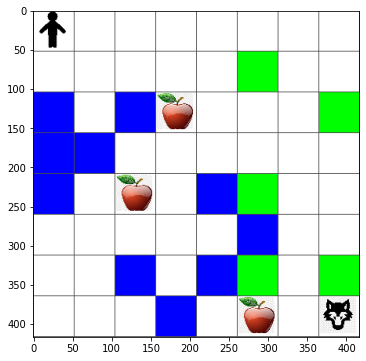

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## アクションとポリシー

この例では、ピーターの目標はリンゴを見つけることであり、オオカミやその他の障害物を避けることです。そのために、彼は基本的に歩き回ってリンゴを見つけることができます。したがって、どの位置においても、次のアクションのいずれかを選ぶことができます：上、下、左、右。これらのアクションを辞書として定義し、それを対応する座標の変化のペアにマッピングします。例えば、右に移動する（`R`）場合は、ペア `(1,0)` に対応します。


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

私たちのエージェント（Peter）の戦略は、いわゆる**ポリシー**によって定義されます。ここでは、最も単純なポリシーである**ランダムウォーク**について考えてみましょう。

## ランダムウォーク

まず、ランダムウォーク戦略を実装することで問題を解決してみましょう。


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

ランダムウォーク実験を何度か実行し、平均ステップ数を確認してみましょう:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## 報酬関数

ポリシーをより賢くするためには、どの動きが他より「良い」のかを理解する必要があります。


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-ラーニング

Q-テーブル、または多次元配列を作成します。ボードのサイズが `width` x `height` であるため、Q-テーブルは形状が `width` x `height` x `len(actions)` のnumpy配列で表現できます。


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Q-テーブルをプロット関数に渡して、ボード上でテーブルを視覚化します:


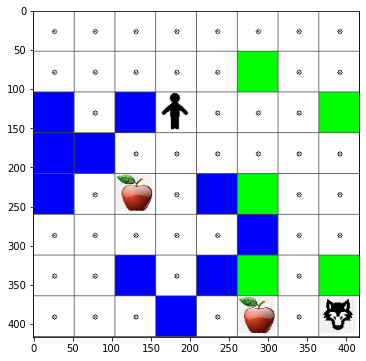

In [9]:
m.plot(Q)

## Q学習の本質: ベルマン方程式と学習アルゴリズム

学習アルゴリズムの疑似コードを記述します:

* 全ての状態と行動に対して、Q-テーブル Q を同じ値で初期化する
* 学習率 $\alpha\leftarrow 1$ を設定する
* シミュレーションを何度も繰り返す
   1. ランダムな位置から開始する
   1. 繰り返す
        1. 状態 $s$ で行動 $a$ を選択する
        2. 行動を実行し、新しい状態 $s'$ に移動する
        3. ゲーム終了条件に達するか、総報酬が小さすぎる場合 - シミュレーションを終了する  
        4. 新しい状態で報酬 $r$ を計算する
        5. ベルマン方程式に従ってQ関数を更新する: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$ に更新する
        7. 総報酬を更新し、$\alpha$ を減少させる

## 探索と活用のバランス

最適なアプローチは、探索と活用のバランスを取ることです。環境について学習が進むにつれ、最適なルートを選ぶ可能性が高くなりますが、時には未探索の道を選ぶことも重要です。

## Pythonでの実装

これで学習アルゴリズムを実装する準備が整いました。その前に、Q-テーブル内の任意の数値を対応する行動の確率ベクトルに変換する関数が必要です:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

元のベクトルに少量の `eps` を加えることで、初期状態でベクトルのすべての成分が同一の場合にゼロでの除算を回避します。

実際の学習アルゴリズムは、**エポック**とも呼ばれる5000回の実験を実行します。


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

このアルゴリズムを実行した後、Qテーブルは各ステップでのさまざまな行動の魅力を定義する値で更新されるはずです。ここでテーブルを視覚化してください:


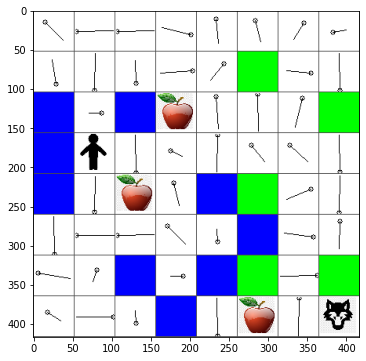

In [12]:
m.plot(Q)

## ポリシーの確認

Q-Tableは各状態における各アクションの「魅力」を示しているため、これを使って効率的なナビゲーションを定義するのは非常に簡単です。最も単純な場合、Q-Tableの値が最も高いアクションを選択するだけで済みます。


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

コードを何度か試してみると、時々「停止」してしまい、ノートブックのSTOPボタンを押して中断する必要があることに気付くかもしれません。

> **タスク 1:** `walk`関数を修正して、パスの最大長を特定のステップ数（例えば100）に制限し、上記のコードが時々この値を返す様子を確認してください。

> **タスク 2:** `walk`関数を修正して、以前に訪れた場所に戻らないようにしてください。これにより`walk`がループするのを防ぐことができますが、エージェントが脱出できない場所に「閉じ込められる」可能性は依然としてあります。


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


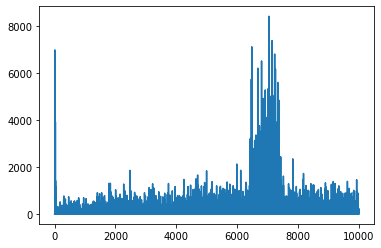

In [15]:
plt.plot(lpath)

最初に平均経路長が増加しているのが見て取れます。これは、おそらく環境について何も知らない状態では、悪い状態（水やオオカミ）に陥りやすいからでしょう。しかし、知識を得てそれを活用し始めると、環境をより長く探索できるようになりますが、それでもまだリンゴの場所を正確に把握しているわけではありません。

十分に学習が進むと、エージェントが目標を達成するのが容易になり、経路長は減少し始めます。ただし、まだ探索を続けているため、最適な経路から外れて新しい選択肢を試すことがあり、その結果、経路が最適よりも長くなることがあります。

また、このグラフで観察できるのは、ある時点で経路長が急激に増加していることです。これはプロセスの確率的な性質を示しており、新しい値でQ-テーブルの係数を上書きすることで「台無し」にしてしまう可能性があることを意味します。これを最小限に抑えるためには、学習率を下げることが理想的です（つまり、トレーニングの終盤ではQ-テーブルの値を小さな値でのみ調整するようにします）。

全体として、学習プロセスの成功と質は、学習率、学習率の減衰、割引率といったパラメータに大きく依存することを覚えておくことが重要です。これらはしばしば**ハイパーパラメータ**と呼ばれ、トレーニング中に最適化する**パラメータ**（例: Q-テーブルの係数）とは区別されます。最適なハイパーパラメータ値を見つけるプロセスは**ハイパーパラメータ最適化**と呼ばれ、これ自体が別のトピックに値する重要なテーマです。


## 演習
#### より現実的な「ピーターと狼」の世界

私たちのシナリオでは、ピーターはほとんど疲れたり空腹になったりすることなく自由に動き回ることができました。しかし、より現実的な世界では、ピーターは時々座って休む必要があり、また自分自身に食べ物を与える必要があります。以下のルールを実装して、私たちの世界をより現実的にしてみましょう：

1. 一つの場所から別の場所へ移動することで、ピーターは**エネルギー**を失い、**疲労**を蓄積します。
2. ピーターはリンゴを食べることでエネルギーを回復できます。
3. ピーターは木の下や草の上で休むことで疲労を解消できます（つまり、木や草がある場所（緑のフィールド）に移動する）。
4. ピーターは狼を見つけて倒す必要があります。
5. 狼を倒すためには、ピーターは一定のエネルギーと疲労レベルを持っている必要があります。そうでない場合、戦いに負けてしまいます。

ゲームのルールに従って報酬関数を修正し、強化学習アルゴリズムを実行してゲームに勝つための最適な戦略を学習し、ランダムウォークとあなたのアルゴリズムを比較して、勝敗の数を評価してください。

> **Note**: ハイパーパラメータを調整する必要があるかもしれません。特にエポック数です。ゲームの成功（狼との戦い）は稀なイベントであるため、より長いトレーニング時間が必要になることが予想されます。



---

**免責事項**:  
この文書は、AI翻訳サービス [Co-op Translator](https://github.com/Azure/co-op-translator) を使用して翻訳されています。正確性を追求しておりますが、自動翻訳には誤りや不正確さが含まれる可能性があることをご承知おきください。原文（元の言語で記載された文書）が信頼できる情報源と見なされるべきです。重要な情報については、専門の人間による翻訳を推奨します。この翻訳の使用に起因する誤解や誤認について、当社は一切の責任を負いません。
